# Burkina Faso – phone access (3 groups) and attention
This notebook is a **robust** version that does two things:

1. **Compares attention** across 3 phone-access groups you defined:
   - `0` → owns phone, does **not** share
   - `1` → does **not** own phone, **does** share / has access through family
   - `2` → does **not** own phone, **does not** share (no access)
2. **Keeps the earlier paper-ready model** for **owners only** (usage × duration).

It will **stop with a clear error** if any of the required columns are missing.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1200)

## 1. Load data

In [ ]:
DATA_PATH = Path()
df = pd.read_csv(DATA_PATH)
print('Rows and columns:', df.shape)
df.head()

Rows and columns: (672, 55)


,ID,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,15,10,1,2.266667,3.166667,4.583333,1,4,1,1,3,4,2,1,1,1,4,2,3,2,4,2,3,4,2,4,3,2,4,4,3,3,4,5,6,6,4,5,4,3,6,4,3,5,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,2,14,10,0,3.000000,3.583333,4.250000,1,4,4,3,4,4,2,4,4,2,4,3,1,3,2,4,4,4,4,3,4,1,4,4,4,4,3,4,3,3,5,6,6,1,6,6,3,4,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,3,14,10,1,1.333333,3.000000,1.083333,1,1,1,1,1,1,3,1,1,1,1,1,3,2,1,4,1,4,4,4,1,4,4,1,4,4,1,1,1,1,1,1,2,1,1,1,1,1,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0
3,4,15,10,1,2.000000,2.916667,3.916667,1,1,4,1,3,1,2,1,3,1,3,1,4,2,2,4,3,2,4,4,4,1,3,2,4,3,1,6,7,6,4,2,3,2,4,3,2,5,3,1.0,0.0,0,1,0,0,School,12.0,1.0
4,5,16,10,0,2.066667,2.666667,3.833333,3,3,1,2,1,1,3,2,2,3,2,1,2,1,4,4,2,4,1,4,3,1,3,3,2,3,2,4,4,4,4,5,4,2,4,5,3,5,2,16.0,0.0,0,0,1,0,Communication,192.0,1.0


## 2. Check required columns

In [12]:
required = [
    'Attention_Score',   # DV
    'Has_phone',         # 1 if owns phone
    'PhoneUse_Score',    # phone usage/intensity
    'Phone_total_months',# how long they had phone
    'Age',
    'Class',
    'Sex_binary',        # 1=female,0=male
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f'Missing required columns: {missing}. Please fix names in the cell above.')
print('All required columns are present')
print('Extra columns in your file:', [c for c in df.columns if c not in required][:20])

All required columns are present
Extra columns in your file: ['ID', 'Happiness_Score', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'H1', 'H2', 'H3']


## 3. Building the 3 phone-access groups

Final coding:
- 0 → owns phone, does not share
- 1 → does not own, does share
- 2 → does not own, does not share

In [21]:
SHARE_COL = 'share phone family'

def classify_phone_ownership(row):
    # 0 = owns phone, does not share
    if row['Has_phone'] == 1:
        return 0

    # no own phone
    if SHARE_COL is not None:
        val = row[SHARE_COL]
        val_norm = str(val).strip().lower() if pd.notna(val) else ""
        if val_norm in {'1'}:
            return 1   # doesn't own, DOES share
        if val_norm in {'0'}:
            return 2   # doesn't own, DOESN'T share

    # if share col missing or unreadable, default to no share
    return 2

df['phone_ownership'] = df.apply(classify_phone_ownership, axis=1)
print(df['phone_ownership'].value_counts(dropna=False).sort_index())


phone_ownership
0    400
1     89
2    183
Name: count, dtype: int64


## 4. Descriptive stats per group

In [14]:
desc = df.groupby('phone_ownership')['Attention_Score'].describe()
print(desc)


                 count      mean       std       min       25%       50%       75%       max
phone_ownership                                                                             
0                400.0  2.380333  0.476659  1.066667  2.066667  2.333333  2.666667  4.000000
1                 89.0  2.448689  0.528268  1.400000  2.066667  2.466667  2.800000  3.866667
2                183.0  2.506375  0.598290  1.200000  2.100000  2.466667  2.800000  4.000000


## 5. Plot attention by group

<Figure size 600x400 with 0 Axes>

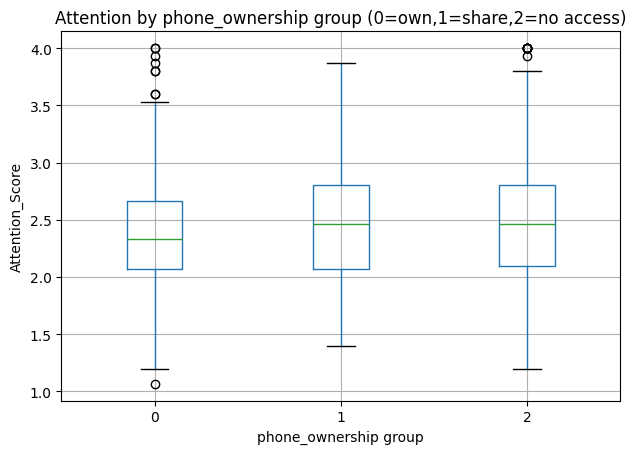

In [15]:
plt.figure(figsize=(6,4))
df.boxplot(column='Attention_Score', by='phone_ownership')
plt.suptitle('')
plt.title('Attention by phone_ownership group (0=own,1=share,2=no access)')
plt.xlabel('phone_ownership group')
plt.ylabel('Attention_Score')
plt.tight_layout()
plt.show()

## 6. Regression: do groups differ after controls?
We use **group 2 (no access)** as the reference. That lets you answer your question directly.
Model:  
`Attention_Score ~ (phone3) + Age + Class + Sex_binary`

In [16]:
df_reg = df.dropna(subset=['Attention_Score', 'Age', 'Class', 'Sex_binary', 'phone_ownership']).copy()
# make phone_ownership categorical and set order: 2 (ref), 1, 0
df_reg['phone_ownership'] = df_reg['phone_ownership'].astype('category')
df_reg['phone_ownership'] = df_reg['phone_ownership'].cat.reorder_categories([2, 1, 0], ordered=True)

formula_groups = 'Attention_Score ~ (phone_ownership) + Age + Class + Sex_binary'
model_groups = smf.ols(formula=formula_groups, data=df_reg).fit()
model_groups.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Attention_Score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.529
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           0.000456
Time:                        12:22:51   Log-Likelihood:                -504.16
No. Observations:                 672   AIC:                             1020.
Df Residuals:                     666   BIC:                             1047.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.8351      0.128     22.199      0.000       2.584       3.086
phone_ownership[T.1]    -0.0568      0.067     -0.853      0.394      -0.187       0.074
phone_ownership[T.0]    -0.0547      0.050     -1.102      0.271      -0.152       0.043
Age                      0.0004      0.013      0.027      0.978      -0.025       0.026
Class                   -0.0430      0.017     -2.590      0.010      -0.076      -0.010
Sex_binary               0.0183      0.041      0.448      0.654      -0.062       0.098
==============================================================================
Omnibus:                       24.902   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.632
Skew:                           0.433   Prob(JB):                     9.99e-07
Kurtosis:                       3.486   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 7. Owners only: does usage depend on how long they had the phone?
This reproduces your first analysis but **only** for `phone_ownership == 0`.

In [17]:
owners = df[df['phone_ownership'] == 0].copy()
owners = owners.dropna(subset=['Attention_Score', 'PhoneUse_Score', 'Phone_total_months'])
owners['PhoneUse_c'] = owners['PhoneUse_Score'] - owners['PhoneUse_Score'].mean()
owners['PhoneMonths_c'] = owners['Phone_total_months'] - owners['Phone_total_months'].mean()
owners['Use_x_Duration'] = owners['PhoneUse_c'] * owners['PhoneMonths_c']

form_inter = (
    'Attention_Score ~ PhoneUse_c + PhoneMonths_c + Use_x_Duration + Age + Class + Sex_binary'
)
model_inter = smf.ols(formula=form_inter, data=owners).fit()
model_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Attention_Score   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.723
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           0.000117
Time:                        12:22:51   Log-Likelihood:                -256.77
No. Observations:                 400   AIC:                             527.5
Df Residuals:                     393   BIC:                             555.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5916      0.150     17.235      0.000       2.296       2.887
PhoneUse_c        -0.0965      0.022     -4.414      0.000      -0.140      -0.054
PhoneMonths_c      0.0012      0.001      2.478      0.014       0.000       0.002
Use_x_Duration    -0.0005      0.000     -1.120      0.263      -0.001       0.000
Age                0.0002      0.015      0.017      0.987      -0.029       0.030
Class             -0.0209      0.019     -1.092      0.275      -0.059       0.017
Sex_binary        -0.0132      0.048     -0.272      0.786      -0.108       0.082
==============================================================================
Omnibus:                       14.434   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.357
Skew:                           0.357   Prob(JB):                     0.000170
Kurtosis:                       3.728   Cond. No.                         365.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 8. ML-style prediction

In [18]:
df_ml = df_reg.copy()
df_ml = pd.get_dummies(df_ml, columns=['phone_ownership'], drop_first=True)

features = [c for c in df_ml.columns if c.startswith('phone_ownership_')] + [
    'Has_phone', 'PhoneUse_Score', 'Phone_total_months', 'Age', 'Class', 'Sex_binary'
]
X = df_ml[features].fillna(0)
y = df_ml['Attention_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('Test R2:', r2_score(y_test, preds))
print('Test MAE:', mean_absolute_error(y_test, preds))

Test R2: -0.12552328818309122
Test MAE: 0.4203459600474482
